# A Transformer Model for Language Translation

- Build a translation model from scratch using PyTorch:
    - Preprocess textual data
    - Design the transformer architecture
    - Train the model using parallel computing
    - Evaluate the model performance
    - Generate translation
- Translate a PDF document from German to English

## Install required libraries

In [1]:
# Install compatible core libraries (Torch, TorchText, TorchData)
!pip install -Uqq torch==2.0.1 torchtext==0.15.2 torchdata==0.6.1

# 🔤 NLP + Utility Libraries
!pip install -Uqq portalocker==2.7.0
!pip install -Uqq nltk==3.8.1
!pip install -Uqq spacy==3.7.2
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

# 📄 PDF Utilities
!pip install -Uqq pdfplumber==0.9.0
!pip install -Uqq fpdf==1.7.2

# Download required files
!wget -q 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Multi30K_de_en_dataloader.py'
!wget -q 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/transformer.pt'
!wget -q 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/input_de.pdf'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.

## Import Required Libraries

In [2]:
# Standard library imports
import math
import warnings
from typing import Iterable, List

# Third-party imports
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Transformer
import matplotlib.pyplot as plt
from tqdm import tqdm

# Specialized imports with error handling
try:
    from torchtext.datasets import multi30k, Multi30k
    TORCHTEXT_AVAILABLE = True
    print("TorchText datasets imported successfully")
except (OSError, ImportError) as e:
    print(f"TorchText import failed: {e}")
    print("Using alternative dataset loading from downloaded file")
    TORCHTEXT_AVAILABLE = False

    # Import the alternative dataloader
    try:
        from Multi30K_de_en_dataloader import *
        print("Alternative Multi30K dataloader imported successfully")
    except ImportError:
        print("Alternative dataloader not found. Make sure Multi30K_de_en_dataloader.py is downloaded")

from nltk.translate.bleu_score import sentence_bleu

# Warning suppression
def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')

TorchText datasets imported successfully


In [3]:
# @title Define Special Symbols and Indices

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

## DataLoader

In the English-German Multi30K dataset, first load the data and break down sentences into words or smaller pieces, called tokens. From these tokens, create a unique list or vocabulary. Each token is then turned into a specific number using this vocabulary. Because sentences can be of different lengths,  add padding to make them all the same size in a batch. All this processed data is then organized into a PyTorch DataLoader, making it easy to use for training neural networks.

In [4]:
%run Multi30K_de_en_dataloader.py

In [5]:
# Given the exploratory work, use a batch size of one

train_dataloader, _ = get_translation_dataloaders(batch_size = 1)

In [6]:
# To obtain diverse examples, we can cycle through multiple samples
# since the dataset is sorted by length.

data_itr=iter(train_dataloader)

for n in range(1000):
    german, english= next(data_itr)

In [7]:
# The dataset is structured as sequence-batch-feature,
# rather than the typical batch-feature-sequence.
# For compatibility with our utility functions, we can transpose the dataset.

german=german.T
english=english.T

Print out the text by converting the indexes to words using ```index_to_german``` and ```index_to_english```

In [8]:
for n in range(5):
    german, english= next(data_itr)

    print("sample {}".format(n))
    print("german input")
    print(index_to_german(german))
    print("english target")
    print(index_to_eng(english))
    print("_________\n")

sample 0
german input
<bos> Ein Feuerwehrangehöriger arbeitet bei einem Brand . <eos>
english target
<bos> A firefighter is working at a fire . <eos>
_________

sample 1
german input
<bos> Ein Mann spielt auf einem Flügel . <eos>
english target
<bos> A man playing a black grand piano . <eos>
_________

sample 2
german input
<bos> Ein brauner Hund spielt im Schnee . <eos>
english target
<bos> A brown dog plays in the snow . <eos>
_________

sample 3
german input
<bos> Mehrere Hunde in einem winterlichen Ambiente . <eos>
english target
<bos> Several dogs grouped together in a winter setting . <eos>
_________

sample 4
german input
<bos> Ein Mann klettert einen Felsen hoch . <eos>
english target
<bos> A man climbs up a rock . <eos>
_________



In [9]:
# Check if a GPU is available and use it; otherwise, you'll use the CPU.

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

## Prepare

### Masking

During training, the entire sequence is visible to the model and used as input to learn patterns. In contrast, for prediction, the future sequence is not available. To do this, employ masking to simulate this lack of future data, ensuring the model learns to predict without seeing the actual next tokens. It is crucial for ensuring certain positions are not attended to. The function ```generate_square_subsequent_mask``` produces an upper triangular matrix, which ensures that during decoding, a token can't attend to future tokens.

In [10]:
def generate_square_subsequent_mask(sz,device=DEVICE):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

The ```create_mask``` function, on the other hand, generates both source and target masks, as well as padding masks based on the provided source and target sequences. The padding masks ensure that the model doesn't attend to pad tokens, providing a streamlined attention.

In [11]:
def create_mask(src, tgt,device=DEVICE):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

### Positional encoding
The transformer model doesn't have built-in knowledge of the order of tokens in the sequence. To give the model this information, positional encodings are added to the tokens embeddings. These encodings have a fixed pattern based on their position in the sequence.


In [12]:
# Add positional information to the input tokens
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

### Token embedding
Token embedding, also known as word embedding or word representation, is a way to convert words or tokens from a text corpus into numerical vectors in a continuous vector space. Each unique word or token in the corpus is assigned a fixed-length vector where the numerical values represent various linguistic properties of the word, such as its meaning, context, or relationships with other words.

The `TokenEmbedding` class converts numerical tokens into embeddings.

In [13]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

## Transformer architecture for language translation
This process relies on an encoder-decoder architecture.

### Tokenization and positional encoding
The source language text (the input sequence) is tokenized, which means it's divided into individual words or subwords. These tokens are then converted into numerical representations. To preserve word order information, positional encodings are added to these numerical tokens.

### Encoder processing
Next pass these numerical tokens through the encoder. The encoder is composed of multiple layers, each containing self-attention mechanisms and feed-forward neural networks. This architecture allows the transformer model to process the entire input sequence at once, in contrast to traditional RNN-based models like LSTMs or GRUs, which process input sequentially.

### Decoding with teacher forcing
During training, the target language text (the correct output sequence) is also tokenized and converted into numerical tokens. "Teacher forcing" is a training technique where the decoder is provided with the target tokens as input. The decoder uses both the encoder's output and the previously generated tokens (starting with a special start-of-sequence token) to predict the next token in the sequence.

### Output generation and loss calculation
The decoder generates the translated sequence token by token. At each step, the decoder predicts the next token in the target sequence. The predicted sequence from the decoder is then compared to the actual target sequence using a loss function, typically cross-entropy loss for translation tasks. This loss function quantifies how well the model's predictions match the true target sequence.

## Seq2SeqTransformer
Represents the core of the transformer model for language translation.

- **Data loading:** Loading and preparing the training data, which includes source language text and corresponding target language text.

- **Model initialization:** Initializing the transformer model, including setting up the encoder, decoder, positional encodings, and other necessary components.

- **Optimizer setup:** Choosing an appropriate optimizer, such as Adam, and defining learning rate schedules to update model parameters during training.

- **Training loop:** Iterating through the training data for multiple epochs, using teacher forcing to guide the model's learning process.

- **Loss monitoring:** Recording and potentially plotting training losses for each epoch. These losses indicate how well the model is learning to perform language translation.

In [14]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()

        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        outs =outs.to(DEVICE)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

## Inference


The diagram below illustrates the sequence prediction or inference process. You can begin by feeding the indices of your desired translation sequence into the encoder, represented by the lower-left orange section. The resulting embeddings from the encoder are then channeled into the decoder, highlighted in green. Alongside, a start token is introduced at the beginning of the decoder input, as depicted at the base of the green segment.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/predict_transformers.png" alt="transformer" width="60%">

The decoder's output is then mapped onto a vocabulary-sized vector using a linear layer. Following this, a softmax function converts these vector scores into probabilities. The highest probability, as determined by the argmax function, provides the index of your predicted word within the translated sequence. This predicted index is fed back into the decoder in conjunction with the initial sequence, setting the stage to determine the subsequent word in the translation. This autoregressive process is demonstrated by the arrow pointing to form the top of the decoder, in green, to the bottom.


In [15]:
torch.manual_seed(0)

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

In [16]:
 # Load the weights of apretrained transformer model from the file 'transformer.pt'.

 transformer.load_state_dict(torch.load('transformer.pt', map_location=DEVICE, ))

<All keys matched successfully>

In [17]:
for n in range(100):
    src ,tgt= next(data_itr)

print("English target",index_to_eng(tgt))
print("German input",index_to_german(src))

English target <bos> A construction worker is talking on the phone in a train tunnel . <eos>
German input <bos> Ein Bauarbeiter telefoniert in einem Bahntunnel . <eos>


In [18]:
num_tokens = src.shape[0]
num_tokens

9

In [19]:
src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(DEVICE )
src_mask[0:10]

tensor([[False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False]])

In [20]:
src_=src[:,0].unsqueeze(1)
print(src_.shape)
print(src.shape)

torch.Size([9, 1])
torch.Size([9, 1])


In [21]:
memory = transformer.encode(src_, src_mask)
memory.shape

torch.Size([9, 1, 512])

In [22]:
ys = torch.ones(1, 1).fill_(BOS_IDX).type(torch.long).to(DEVICE)
ys

tensor([[2]])

In [23]:
tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
tgt_mask

tensor([[False]])

In [24]:
out = transformer.decode(ys, memory, tgt_mask)
out.shape

torch.Size([1, 1, 512])

In [25]:
logit = transformer.generator(out[:, -1])
logit.shape

torch.Size([1, 10837])

In [26]:
  _, next_word_index = torch.max(logit, dim=1)
  print("engish output:",index_to_eng(next_word_index))

engish output: A


In [27]:
next_word_index=next_word_index.item()
next_word_index

6

In [28]:
ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word_index)], dim=0)
ys

tensor([[2],
        [6]])

In [29]:
# Update the target mask for the current sequence length.

tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
tgt_mask

tensor([[False,  True],
        [False, False]])

In [30]:
# Decode the current sequence using the transformer and retrieve the output.

out = transformer.decode(ys, memory, tgt_mask)
out = out.transpose(0, 1)
out.shape

torch.Size([1, 2, 512])

In [31]:
# Get the word probabilities for the last predicted word.
prob = transformer.generator(out[:, -1])

# Find the word index with the highest probability.
_, next_word_index = torch.max(prob, dim=1)

# Print the predicted English word.
print("English output:", index_to_eng(next_word_index))

# Convert the tensor value to a Python scalar.
next_word_index = next_word_index.item()

English output: construction


In [33]:
ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word_index)], dim=0)
print("English output:",index_to_eng(ys))

English output: <bos> A construction construction


 Starting with the initial output of the encoder and the token, the decoder's output is looped back into the decoder until the translated sequence is fully decoded. This cycle continues until the length of the new translated sequence matches that of the original sequence.

In [34]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

In [35]:
src
src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(DEVICE )

In [36]:
max_len=src.shape[0]+5
max_len

14

In [41]:
ys=greedy_decode(transformer, src, src_mask, max_len, start_symbol=BOS_IDX)
print("English  (ys):",index_to_eng(ys))
print("English (tgt):",index_to_eng(tgt))

English  (ys): <bos> A construction worker is talking on a train in a train train .
English (tgt): <bos> A construction worker is talking on the phone in a train tunnel . <eos>


### Decoding the differences: Training vs. inference in neural machine translation

During the inference phase, when the model is deployed for actual translation tasks, the decoder generates the sequence without access to the expected target sequence. Instead, it bases its predictions on the encoder's output and the tokens it has produced in sequence so far. The process is autoregressive, with the decoder continually predicting the next token until it outputs an end-of-sequence token, indicating the translation is complete.

The key difference between the training and inference stages lies in the inputs to the decoder. During training, the decoder benefits from exposure to the ground truth--receiving the exact target sequence tokens incrementally through a technique known as "teacher forcing." This approach is in stark contrast to some other neural network architectures that rely on the network's previous predictions as inputs during training. Once training concludes, the datasets used resemble those employed in more conventional neural network models, providing a familiar foundation for comparison and evaluation.

First, import `CrossEntropyLoss` loss and create a Cross Entropy Loss object The loss will  not be calculated when the token with index `PAD_IDX` an input.

In [42]:
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss(ignore_index=PAD_IDX)

In [43]:
tgt_input = tgt[:-1, :]
print(index_to_eng(tgt_input))
print(index_to_eng(tgt))

<bos> A construction worker is talking on the phone in a train tunnel .
<bos> A construction worker is talking on the phone in a train tunnel . <eos>


In [44]:
# Create the required masks

src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

print(f"Shape of src_mask: {src_mask.shape}")
print(f"Shape of tgt_mask: {tgt_mask.shape}")
print(f"Shape of src_padding_mask: {src_padding_mask.shape}")
print(f"Shape of tgt_padding_mask: {tgt_padding_mask.shape}")

Shape of src_mask: torch.Size([9, 9])
Shape of tgt_mask: torch.Size([14, 14])
Shape of src_padding_mask: torch.Size([1, 9])
Shape of tgt_padding_mask: torch.Size([1, 14])


In [45]:
src_padding_mask

tensor([[False, False, False, False, False, False, False, False, False]])

In [46]:
print(tgt_mask)
[index_to_eng( tgt_input[t==0])  for t in tgt_mask] #index_to_eng(tgt_input))

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0.,

['<bos>',
 '<bos> A',
 '<bos> A construction',
 '<bos> A construction worker',
 '<bos> A construction worker is',
 '<bos> A construction worker is talking',
 '<bos> A construction worker is talking on',
 '<bos> A construction worker is talking on the',
 '<bos> A construction worker is talking on the phone',
 '<bos> A construction worker is talking on the phone in',
 '<bos> A construction worker is talking on the phone in a',
 '<bos> A construction worker is talking on the phone in a train',
 '<bos> A construction worker is talking on the phone in a train tunnel',
 '<bos> A construction worker is talking on the phone in a train tunnel .']

When we call `model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask)`,  the forward method of the `Seq2SeqTransformer` class. This process generates logits for the target sequence, which can then be translated into actual tokens by taking the highest probability prediction at each step in the sequence.

## Loss

In [47]:
logits = transformer(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

print("output shape",logits.shape)
print("target shape",tgt_input.shape)
print("source shape ",src.shape)

output shape torch.Size([14, 1, 10837])
target shape torch.Size([14, 1])
source shape  torch.Size([9, 1])


In [48]:
tgt_out = tgt[1:, :]
print(tgt_out.shape)
[index_to_eng(t)  for t in tgt_out]

torch.Size([14, 1])


['A',
 'construction',
 'worker',
 'is',
 'talking',
 'on',
 'the',
 'phone',
 'in',
 'a',
 'train',
 'tunnel',
 '.',
 '<eos>']

In [49]:
tgt_out_flattened = tgt_out.reshape(-1)
print(tgt_out_flattened.shape)
tgt_out_flattened

torch.Size([14])


tensor([  6, 264, 348,  10, 121,   9,   8, 360,   7,   4, 240, 825,   5,   3])

In [50]:
["input: {} target: {}".format(index_to_eng( tgt_input[m==0]),index_to_eng( t))  for m,t in zip(tgt_mask,tgt_out)]

['input: <bos> target: A',
 'input: <bos> A target: construction',
 'input: <bos> A construction target: worker',
 'input: <bos> A construction worker target: is',
 'input: <bos> A construction worker is target: talking',
 'input: <bos> A construction worker is talking target: on',
 'input: <bos> A construction worker is talking on target: the',
 'input: <bos> A construction worker is talking on the target: phone',
 'input: <bos> A construction worker is talking on the phone target: in',
 'input: <bos> A construction worker is talking on the phone in target: a',
 'input: <bos> A construction worker is talking on the phone in a target: train',
 'input: <bos> A construction worker is talking on the phone in a train target: tunnel',
 'input: <bos> A construction worker is talking on the phone in a train tunnel target: .',
 'input: <bos> A construction worker is talking on the phone in a train tunnel . target: <eos>']

Now, calculate the loss as the output from the transformer's decoder is provided as input to the cross-entropy loss function along with the target sequence values. Given that the transformer's output has the dimensions sequence length, batch size, and features (vocab_size), it's necessary to reshape this output to align with the standard input format required by the cross-entropy loss function. This step ensures that the loss is calculated correctly, comparing the predicted sequence against the ground truth at each time step across the batch using the reshape method

In [51]:
loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
print(loss)

tensor(0.4338, grad_fn=<NllLossBackward0>)


## Evaluate
By following these procedures, we can develop a function that is capable of making predictions and subsequently computing the corresponding loss on the validation data, you will use this function later on.

In [52]:
def evaluate(model):
    model.eval()
    losses = 0



    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

# Training the model
Incorporating the previously steps, proceed to train the model. Apart from these specific procedures, the overall training process conforms to the conventional methods employed in neural network training.

In [53]:
def train_epoch(model, optimizer, train_dataloader):
    model.train()
    losses = 0

    # Wrap train_dataloader with tqdm for progress logging
    train_iterator = tqdm(train_dataloader, desc="Training", leave=False)

    for src, tgt in train_iterator:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        src_mask = src_mask.to(DEVICE)
        tgt_mask = tgt_mask.to(DEVICE)
        src_padding_mask = src_padding_mask.to(DEVICE)
        tgt_padding_mask = tgt_padding_mask.to(DEVICE)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = logits.to(DEVICE)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

        # Update tqdm progress bar with the current loss
        train_iterator.set_postfix(loss=loss.item())

    return losses / len(list(train_dataloader))

In [54]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

In [55]:
train_dataloader, val_dataloader = get_translation_dataloaders(batch_size = BATCH_SIZE)

In [56]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
transformer = transformer.to(DEVICE)

In [57]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [58]:
# Initialize the train loss and validation loss list.

TrainLoss=[]
ValLoss=[]

In [59]:
from timeit import default_timer as timer
NUM_EPOCHS = 5

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, train_dataloader)
    TrainLoss.append(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer)
    ValLoss.append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
torch.save(transformer.state_dict(), 'transformer_de_to_en_model.pt')

Epoch: 1, Train loss: 5.076, Val loss: 4.376, Epoch time = 1766.181s


KeyboardInterrupt: 

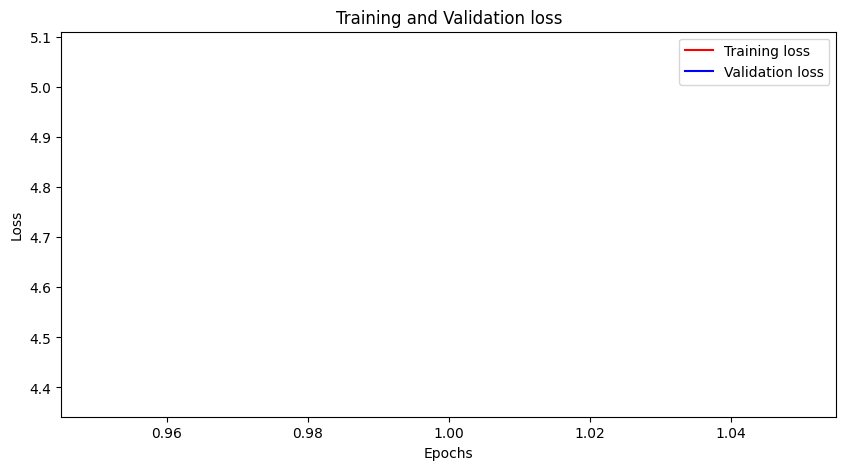

In [60]:
# Plot the loss for the training and validation data.

epochs = range(1, len(TrainLoss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, TrainLoss, 'r', label='Training loss')
plt.plot(epochs,ValLoss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Loading the saved model

We can load the pretrained model that is provided.

In [61]:
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/transformer_de_to_en_model.pt'
transformer.load_state_dict(torch.load('transformer_de_to_en_model.pt',map_location=torch.device('cpu')))

--2025-07-09 12:07:50--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/transformer_de_to_en_model.pt
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144561810 (138M) [binary/octet-stream]
Saving to: ‘transformer_de_to_en_model.pt’

transformer_de_to_e 100%[===================>] 137.86M  38.9MB/s    in 4.2s    

2025-07-09 12:07:55 (33.0 MB/s) - ‘transformer_de_to_en_model.pt’ saved [144561810/144561810]



<All keys matched successfully>

## Translation and evaluation

Using the greedy_decode function that we defined earlier, we can create a translator function that generates English translation of an input German text.

In [62]:
# translate input sentence into target language

def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [63]:
for n in range(5):
    german, english= next(data_itr)

    print("German Sentence:",index_to_german(german).replace("<bos>", "").replace("<eos>", ""))
    print("English Translation:",index_to_eng(english).replace("<bos>", "").replace("<eos>", ""))
    print("Model Translation:",translate(transformer,index_to_german(german)))
    print("_________\n")

German Sentence:  Zwei Bauarbeiter arbeiten auf einem Gerüst . 
English Translation:  Two construction workers are working on a scaffold . 
Model Translation:  Two construction workers are working on a concrete concrete concrete concrete concrete concrete concrete concrete concrete concrete concrete concrete
_________

German Sentence:  Ein Mann steht auf den Gleisen . 
English Translation:  A man standing on the tracks . 
Model Translation:  A man stands on the concrete concrete concrete concrete area on the city skyline . 
_________

German Sentence:  Bauarbeiter reparieren die Wände einer U-Bahn . 
English Translation:  Construction workers repair walls of a subway . 
Model Translation:  Construction workers repair concrete concrete concrete concrete concrete concrete concrete concrete concrete concrete concrete concrete concrete concrete concrete concrete
_________

German Sentence:  Bauarbeiter bringen Verkleidungen im Tunnelinneren an . 
English Translation:  Construction workers

### Evaluation with BLEU score
To evaluate the generated translations, a function calculate_bleu_score is introduced. It computes the BLEU score, a common metric for machine translation quality, by comparing the generated translation to reference translations. The BLEU score provides a quantitative measure of translation accuracy.

The code also includes an example of calculating the BLEU score for a generated translation.

In [64]:
def calculate_bleu_score(generated_translation, reference_translations):
    # convert the generated translations and reference translations into the expected format for sentence_bleu
    references = [reference.split() for reference in reference_translations]
    hypothesis = generated_translation.split()

    # calculate the BLEU score
    bleu_score = sentence_bleu(references, hypothesis)

    return bleu_score

In [65]:
generated_translation = translate(transformer,"Ein brauner Hund spielt im Schnee .")

reference_translations = [
    "A brown dog is playing in the snow .",
    "A brown dog plays in the snow .",
    "A brown dog is frolicking in the snow .",
    "In the snow, a brown dog is playing ."

]

bleu_score = calculate_bleu_score(generated_translation, reference_translations)
print("BLEU Score:", bleu_score, "for",generated_translation)

BLEU Score: 1.0 for  A brown dog plays in the snow . 


## Translating a document
Translate a PDF in German to English, with the sequence-to-sequence transformer model.

1. **Define the translation function** `translate_pdf` that takes the following parameters:
   - `input_file`: The path to the input PDF file to be translated.
   - `translator_model`: A model or function that will handle the translation of text.
   - `output_file`: The path where the translated PDF will be saved.

2. **Read and translate the PDF**:
   Use `pdfplumber` to open and read the text from each page of the input PDF. Translate the extracted text using the `translator_model`.

3. **Format and write the translated text to a new PDF**:
   - Use `textwrap` to wrap the translated text so that it fits within the A4 page width.
   - Create a new PDF with `FPDF` and add the wrapped translated text to it.
   - Save the new PDF with the translated text to `output_file`.

In [66]:
import pdfplumber
import textwrap
from fpdf import FPDF

def translate_pdf(input_file, translator_model,output_file):
    translated_text = ""

    # Read the input PDF file
    with pdfplumber.open(input_file) as pdf:


        # Extract text from each page of the PDF
        for page in pdf.pages:
            text_content = page.extract_text()
            num_pages = len(pdf.pages)
            a4_width_mm = 210
            pt_to_mm = 0.35
            fontsize_pt = 10
            fontsize_mm = fontsize_pt * pt_to_mm
            margin_bottom_mm = 10
            character_width_mm = 7 * pt_to_mm
            width_text = a4_width_mm / character_width_mm

            pdf = FPDF(orientation='P', unit='mm', format='A4')
            pdf.set_auto_page_break(True, margin=margin_bottom_mm)
            pdf.add_page()
            pdf.set_font(family='Courier', size=fontsize_pt)
            # Split the text into sentences
            sentences = text_content.split(".")

            # Translate each sentence using the custom translator model
            for sentence in sentences:
                translated_sentence = translate(translator_model,sentence)
                lines = textwrap.wrap(translated_sentence, width_text)

                if len(lines) == 0:
                    pdf.ln()

                for wrap in lines:
                    pdf.cell(0, fontsize_mm, wrap, ln=1)

            pdf.output(output_file, 'F')

TEST

In [67]:
# A document in German

!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/input_de.pdf'

--2025-07-09 12:08:20--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/input_de.pdf
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27628 (27K) [application/pdf]
Saving to: ‘input_de.pdf.6’

input_de.pdf.6      100%[===================>]  26.98K  --.-KB/s    in 0.004s  

2025-07-09 12:08:20 (7.02 MB/s) - ‘input_de.pdf.6’ saved [27628/27628]



In [68]:
input_file_path = "input_de.pdf"
output_file = 'output_en.pdf'
translate_pdf(input_file_path, transformer,output_file)
print("Translated PDF file is saved as:", output_file)

Translated PDF file is saved as: output_en.pdf
